In [1]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
from pprint import pprint

# Import Static Data
from nba_api.stats.static import players
from nba_api.stats.static import teams

# Import Endpoints
from nba_api.stats.endpoints import commonplayerinfo
from nba_api.stats.endpoints import playercareerstats
from nba_api.stats.endpoints import playerindex


In [2]:
# Create static data CSV files, nest in the resources folder, set index to player or team ID

# Player data to CSV file
all_players = (pd.DataFrame(players.get_players())).set_index("id")
all_players.index.name = 'player_id'
all_players.to_csv("resources/players.csv")
all_players = pd.read_csv("resources/players.csv", index_col = "player_id")

# Team data to CSV file
all_teams = (pd.DataFrame(teams.get_teams())).set_index("id")
all_teams.index.name = 'team_id'
all_teams.to_csv("resources/teams.csv")
all_teams = pd.read_csv("resources/teams.csv", index_col = "team_id")

In [3]:
# read in the csv
all_seasons = pd.read_csv("resources/all_seasons.csv").set_index('player_name')

# set up the removal and renaming of columns 
remove_columns = ['Unnamed: 0']
rename_columns = {'team_abbreviation': 'Team Abbreviation'
                  ,'age': 'Age'
                  ,'player_height': 'Player Height'
                  ,'player_weight': 'Player Weight'
                  ,'college': 'College'
                  ,'country': 'Country'
                  ,'draft_year': 'Draft Year'
                  ,'draft_round': 'Draft Round'
                  ,'draft_number': 'Draft Number'
                  ,'gp': 'Games Played'
                  ,'pts': 'Points'
                  ,'reb': 'Rebounds'
                  ,'ast': 'Assists'
                  ,'net_rating': 'Net Rating'
                  ,'oreb_pct': 'Offensive Rebound Percentage'
                  ,'dreb_pct': 'Defensive Rebound Percentage'
                  ,'usg_pct': 'Usage Percentage'
                  ,'ts_pct': 'True Shooting Percentage'
                  ,'ast_pct': 'Assist Percentage'
                  ,'season': 'Season'}
all_seasons = all_seasons.drop(columns = remove_columns)
all_seasons = all_seasons.rename(columns = rename_columns)

# set the index
all_seasons.index.name = 'Player Name'

#remove any data that is outside of our date range then store in CSV file
all_seasons = all_seasons[(all_seasons['Season'].str[:4] >= '2000') & (all_seasons['Season'].str[:4] <= '2020')]
all_seasons = all_seasons.to_csv("resources/all_seasons_refreshed.csv")


In [4]:
# read the created CSV and print the results
seasons_2000_2020_df = pd.DataFrame(pd.read_csv("resources/all_seasons_refreshed.csv"))
seasons_2000_2020_df.head()

,Player Name,Team Abbreviation,Age,Player Height,Player Weight,College,Country,Draft Year,Draft Round,Draft Number,...,Points,Rebounds,Assists,Net Rating,Offensive Rebound Percentage,Defensive Rebound Percentage,Usage Percentage,True Shooting Percentage,Assist Percentage,Season
0,Jermaine O'Neal,IND,22.0,210.82,102.511792,NaN,USA,1996,1,17,...,12.9,9.8,1.2,0.7,0.111,0.220,0.214,0.501,0.066,2000-01
1,Jerome Kersey,MIL,39.0,200.66,97.522280,Longwood,USA,1984,2,46,...,3.3,2.0,0.7,1.3,0.036,0.196,0.150,0.473,0.098,2000-01
2,Jason Williams,SAC,25.0,185.42,86.182480,Florida,USA,1998,1,7,...,9.4,2.4,5.4,5.4,0.009,0.075,0.167,0.498,0.256,2000-01
3,Jelani McCoy,SEA,23.0,208.28,111.130040,UCLA,USA,1998,2,33,...,4.5,3.6,0.8,-4.2,0.091,0.153,0.155,0.520,0.082,2000-01
4,Jeff McInnis,LAC,26.0,193.04,80.739376,North Carolina,USA,1996,2,37,...,12.9,2.7,5.5,-5.5,0.017,0.071,0.183,0.521,0.270,2000-01


In [5]:
# find different values - unique players, minimum and maximum age, count of teams, total games played
unique_players = pd.DataFrame(seasons_2000_2020_df['Player Name'].unique(), columns = ['Player Name'])
age_range_by_player = pd.DataFrame(seasons_2000_2020_df.groupby('Player Name')['Age'].agg(['min', 'max']))
team_count_by_player = pd.DataFrame(seasons_2000_2020_df.groupby('Player Name')['Team Abbreviation'].nunique())
total_games_by_player = pd.DataFrame(seasons_2000_2020_df.groupby('Player Name')['Games Played'].sum())

# find the number of seasons a player was in (ensure to remove duplicates for and team transfers)
season_count = pd.DataFrame(seasons_2000_2020_df[['Player Name', 'Season']].copy())
season_count = season_count.drop_duplicates(subset = ['Player Name', 'Season'])
season_count = season_count.groupby('Player Name').size().reset_index(name = 'Season Count')

# calculate all of the averages 
mean_numbers = ['Points', 'Rebounds', 'Assists', 'Offensive Rebound Percentage', 
                'Defensive Rebound Percentage', 'Usage Percentage', 'True Shooting Percentage', 
                'Assist Percentage', 'Player Height', 'Player Weight', 'Net Rating']
points = pd.DataFrame(seasons_2000_2020_df.groupby('Player Name')[mean_numbers].mean())

# store the static data (mostly their draft information and background)
static_data = seasons_2000_2020_df[['Player Name', 'College', 'Country', 'Draft Year', 'Draft Round', 'Draft Number']].copy()
static_data = static_data.drop_duplicates(subset = 'Player Name')

# merge the dataframes
merged_df = pd.merge(unique_players, season_count, on = 'Player Name', how = 'left')
merged_df = pd.merge(merged_df, age_range_by_player, on = 'Player Name', how = 'left')
merged_df = pd.merge(merged_df, team_count_by_player, on = 'Player Name', how = 'left')
merged_df = pd.merge(merged_df, total_games_by_player, on = 'Player Name', how = 'left')
merged_df = pd.merge(merged_df, points, on = 'Player Name', how = 'left')
merged_df = pd.merge(static_data, merged_df, on = 'Player Name', how = 'left')

#formatting
new_columns = {'min': 'Min Age', 'max': 'Max Age', 'Team Abbreviation': 'Team Count', 'Games Played': 'Total Games'}
merged_df = merged_df.rename(columns = new_columns)
merged_df = merged_df.set_index('Player Name')

# store data in csv and print results
merged_df.to_csv("resources/player_stats_2000-2020.csv")
merged_df.head()

,College,Country,Draft Year,Draft Round,Draft Number,Season Count,Min Age,Max Age,Team Count,Total Games,...,Rebounds,Assists,Offensive Rebound Percentage,Defensive Rebound Percentage,Usage Percentage,True Shooting Percentage,Assist Percentage,Player Height,Player Weight,Net Rating
Player Name,,,,,,,,,,,,,,,,,,,,,
Jermaine O'Neal,NaN,USA,1996,1,17,14,22.0,35.0,5,800,...,7.728571,1.528571,0.081500,0.211000,0.242429,0.518143,0.091143,210.82,113.624796,1.357143
Jerome Kersey,Longwood,USA,1984,2,46,1,39.0,39.0,1,22,...,2.000000,0.700000,0.036000,0.196000,0.150000,0.473000,0.098000,200.66,97.522280,1.300000
Jason Williams,Florida,USA,1998,1,7,10,25.0,35.0,4,657,...,2.110000,5.440000,0.009600,0.078400,0.180700,0.506500,0.302400,185.42,83.914520,1.060000
Jelani McCoy,UCLA,USA,1998,2,33,6,23.0,30.0,6,176,...,2.566667,0.283333,0.085167,0.200000,0.118833,0.474667,0.041500,208.28,111.886027,-14.350000
Jeff McInnis,North Carolina,USA,1996,2,37,8,26.0,33.0,5,503,...,2.050000,4.312500,0.018500,0.073375,0.173250,0.481500,0.252875,193.04,82.383647,-5.662500


In [30]:
# sort the df by tenure in the 2000-2020 seasons
merged_df_season_sorted = merged_df.sort_values(by='Season Count', ascending=False)

season_bins = [0, 2, 5, 12, 20]
season_labels = ['1', '2-5', '6-12', '>13']

season_df = merged_df.reset_index()[['Player Name', 'Season Count', 'Min Age', 'Max Age', 'Draft Year', 'Draft Number', 'Draft Round', 'College']].copy()
season_df['Season Bins'] = pd.cut(season_df['Season Count'], bins=season_bins ,labels=season_labels ,include_lowest=True)

season_df.groupby('Season Bins')['Player Name'].count()


Season Bins
1       825
2-5     544
6-12    554
>13     138
Name: Player Name, dtype: int64

In [39]:
# sort the df by tenure in the 2000-2020 seasons
merged_df_team_sorted = merged_df.sort_values(by='Team Count', ascending=True)
merged_df_team_sorted

team_bins = [0, 2, 4, 11]
team_labels = ['1', '2-4', '5+']

team_df = merged_df.reset_index()[['Player Name', 'Team Count', 'Season Count', 'Min Age', 'Max Age', 'Draft Year', 'Draft Number', 'Draft Round', 'College']].copy()
team_df['Team Bins'] = pd.cut(team_df['Team Count'], bins=team_bins ,labels=team_labels ,include_lowest=True)
team_df.groupby('Team Bins')['Player Name'].count()


Team Bins
1      1249
2-4     516
5+      296
Name: Player Name, dtype: int64

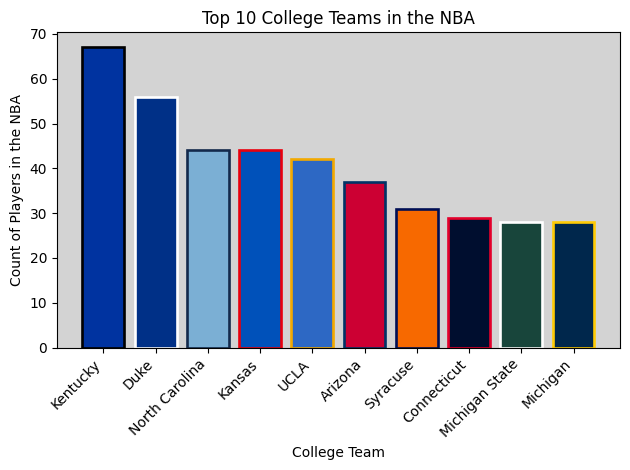

In [69]:
colleges = merged_df.groupby('College').size().reset_index(name = 'Count of Players')
colleges_sorted = pd.DataFrame(colleges.sort_values(by = 'Count of Players', ascending = False).head(10))
colleges_sorted.set_index('College')

college_x_axis = colleges_sorted['College']
college_y_axis = colleges_sorted['Count of Players']

college_colors = pd.DataFrame(pd.read_csv("resources/college_hex_colors.csv"))
primary_color = college_colors['Hex_1']
secondary_color = college_colors['Hex_2']

plt.bar(college_x_axis, college_y_axis, color = primary_color, edgecolor = secondary_color, linewidth = 1.9)

plt.gca().set_facecolor('lightgrey')

plt.xlabel('College Team')
plt.ylabel('Count of Players in the NBA')
plt.title('Top 10 College Teams in the NBA')
# rotation and horizontal alignment
plt.xticks(college_x_axis, rotation = 45, ha='right')
plt.tight_layout()

plt.savefig('figures/college_to_NBA.png')
plt.show()